In [1]:
# Libraries for interfacing with WFDB data
import wfdb
from wfdb import processing



#Classical libraries 
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
import pandas as pd

from scipy.integrate import quad
from scipy.optimize import curve_fit
from numpy import trapz
from scipy.stats import norm



# importing detrending library
import obspy
from obspy.signal import detrend

## Setting possible Path and Key for each Database

In [2]:
paths = {'Fantasia':'physionet.org/files/fantasia/1.0.0/', 'MIT':'physionet.org/files/nsrdb/1.0.0/', 'Chfdb': 'physionet.org/files/chfdb/1.0.0/'}
keys= {'Fantasia':'RR_intervals_original_Fantasia', 'MIT':'RR_intervals_original_MIT', 'Chfdb': 'RR_intervals_original_Chfdb'}

## This function its used to store the ECG data inside the original files into a Pandas Dataframe

In [3]:
def import_ecg(path, files):
    
    '''
    Return ECG and RR_intervals dataframe for Fantasia.
    Return only RR_intervals dataframe for MIT and Chfdb

    Inputs:
        path: path to the data's files
        files: files name without extentions
    
    outputs:
    return:
        ECG_sig: DataFrame with EGC signal for each file in each columns
        RR_intervals: DataFrame where in each columns are stored the interbeats intervals for each files
    '''


    # DataFrames to handle all signals (RAW ECG, RR intervals, Annotations, ...)
    ECG_sig=pd.DataFrame(columns=files)

    RR_intervals = pd.DataFrame(columns=files)

    # Read ECG data from files and store them in Pandas DataFrame
    # Save fields too, for further optional analysis
    signals_dfs=[]
    rr_dfs=[]

    if path == paths['Fantasia']: 
        for file in files:
                sig, fields =  wfdb.rdsamp(path + file, channels=[1]) # channel 1 maps to ECG data
                signals_dfs.append(pd.DataFrame({file: sig.T[0]}))

                xqrs = processing.XQRS(sig=-sig[:,0], fs=fields['fs'])
                xqrs.detect()
                rr=processing.calc_rr(xqrs.qrs_inds, fs=fields['fs'])
            
                rr_dfs.append(pd.DataFrame({file: rr}))

        ECG_sig=pd.concat(signals_dfs, ignore_index=True, axis=1)
        ECG_sig.columns=files

        RR_intervals=pd.concat(rr_dfs, ignore_index=True, axis=1)
        RR_intervals.columns=files
        
        return ECG_sig, RR_intervals
    
    else: 
        for file in files: 
            rr = processing.ann2rr(path+file, extension='ecg')
            rr_dfs.append(pd.DataFrame({file: rr}))
        
        RR_intervals=pd.concat(rr_dfs, ignore_index=True, axis=1)
        RR_intervals.columns=files
    
    return RR_intervals

## This function find problematic files and uses the annotation files to correct them
#### fixing this after loading the data inside the dataframe is a computationally faster way since we all already have the data stored inside the .hdf file and we need only to replace the corrupted column

In [4]:
def clean_df(RR_intervals, path_to_files):
    
    RR = RR_intervals.copy()
    files = list(RR.columns)
    
    #Extracting the problematc files name
    problematic_files = list(RR.columns[RR[files].sum() == 0])
    
    #Removing from the file list the problematic ones
    files = list(RR.columns[RR[files].sum() != 0])
    
    #Removing the columns which bare no value
    RR = RR.drop(problematic_files, axis=1)
    
    #Adding the new columns to the dataframe and the files name to the list
    for file in problematic_files:
        rr = processing.ann2rr(path_to_files+file, extension='ecg')
        RR = pd.concat([RR, pd.Series(rr, name=file)], axis=1)

    new_files = files + problematic_files
    
    return RR, new_files
    

## Function to compute the detrended data and then the increments from the comulative function

In [5]:
def increments(B_df, s_list, polydegree=3):
    '''
    Inputs:
        B: Dataframe with the columns to be detrended
        s_list: List of value of s to be used to detrend B
        polydegree: Polynomial's degree used to detred the data
    
    Output:
        return : List of array containing the detrended data increments for each column of B
    
    '''
    fnames = list(B_df.columns) #columns name list
    list_DB=[]
    
    for s in s_list:
        
        Delta_B_s=[] #empy list to store the increamets for a specific s regardless of the file from which the data come from

        
        for B in B_df[fnames].values.T:
            
            B = B[~np.isnan(B)] #removing all nan values from B     
            nmax_seg=int(np.floor(B.size/(2*s))) #maximum number of possible segments with increment s over B
            
            
            if nmax_seg!= 0: #avoid useless computing power
                
                for indx in range(nmax_seg):
                    detrend.polynomial(B[indx*2*s: (indx+1)*2*s], order=polydegree, plot=False) # for each sliding segment, detrend

                # the whole B but now detrended
                #detrended=B[0:2*s*nmax_seg].copy() #only those that are possible to detrend (have at least the 2s space/segment)
                detrended=B[0:2*s*nmax_seg]
                Delta_s_B_file=np.array([detrended[i+s]-detrended[i] for i in range(2*s*nmax_seg) if i+s< len(detrended)])
                Delta_B_s.append(Delta_s_B_file/np.std(Delta_s_B_file)) #since the std of very patient i svery different from each other we need to normalize the increments and join them togheter
        list_DB.append(np.concatenate(Delta_B_s))
    
    return list_DB


## Defining gaussian and Castaing's functions to fit the data


In [6]:
def gaus(x, mu, sigma, A):
    return A/np.sqrt(2*np.pi*sigma**2)*np.exp(-(x - mu)**2 / (2*sigma**2))

In [7]:
def castaing_integral(x, lambd, sigma_0):
    def little_cast(sigma, lambd, x, sigma_0):
        return 1/(2*np.pi*lambd*sigma**2)*np.exp(-(x**2/sigma**2 + np.log(sigma/sigma_0)**2/lambd**2) / 2)
    result = quad(little_cast, 0, np.inf, args=(lambd, x, sigma_0))
    return result[0]

# scipy_integrate accepts only scalar functions, we can vectorize it this way
Castaing_integral = np.vectorize(castaing_integral)

## Possible database are: Fantasia, MIT, Chfdb

In [9]:
database='Fantasia' 
path = paths[database]
key = keys[database]
files= np.loadtxt(path+'RECORDS', dtype='str')

## This cell is meant to run only when first importing the data

In [10]:
''''if database=='Fantasia': 
    ECG_sig, RR_intervals_original = import_ecg(path, files)

    ECG_sig.to_hdf('ECG_sig.hdf', key=key)
    RR_intervals_original.to_hdf('RR_intervals_original.hdf', key=key)

else:
    RR_intervals_original = import_ecg(path, files)
    RR_intervals_original.to_hdf('RR_intervals_original.hdf', key=key)'''

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learn

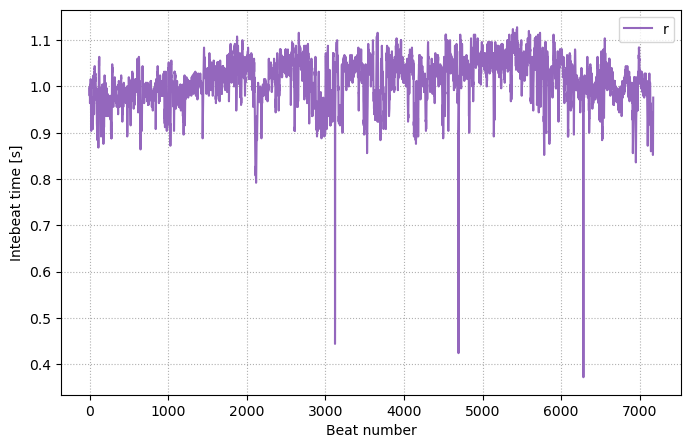

In [15]:
RR = pd.read_hdf('RR_intervals_original.hdf', key=key)
fig = plt.figure(figsize=(8,5))
plt.plot(RR['f1o01']/250, color=colors[8], label='b(i)')
plt.grid(linestyle='dotted')
plt.xlabel('Beat number')
plt.ylabel('Intebeat time [s]')
plt.legend('right down')
#plt.savefig('b_Chfdb.png', bbox_inches='tight')

## Loading the data inside a Dataframe for easier manipulation

In [12]:
RR_intervals_original=pd.read_hdf('RR_intervals_original.hdf', key=key)
RR_intervals_original

,f1o01,f1o02,f1o03,f1o04,f1o05,f1o06,f1o07,f1o08,f1o09,f1o10,...,f2y01,f2y02,f2y03,f2y04,f2y05,f2y06,f2y07,f2y08,f2y09,f2y10
0,249.0,241.0,196.0,309.0,253.0,312.0,248.0,186.0,368.0,227.0,...,NaN,308.0,257.0,189.0,NaN,235.0,244.0,NaN,NaN,NaN
1,245.0,186.0,215.0,311.0,249.0,308.0,246.0,188.0,369.0,225.0,...,NaN,321.0,250.0,183.0,NaN,242.0,218.0,NaN,NaN,NaN
2,246.0,288.0,206.0,310.0,250.0,311.0,239.0,189.0,371.0,219.0,...,NaN,302.0,262.0,186.0,NaN,238.0,217.0,NaN,NaN,NaN
3,250.0,237.0,211.0,316.0,252.0,307.0,257.0,191.0,367.0,220.0,...,NaN,298.0,260.0,188.0,NaN,241.0,216.0,NaN,NaN,NaN
4,244.0,241.0,218.0,316.0,252.0,312.0,251.0,192.0,367.0,221.0,...,NaN,326.0,247.0,189.0,NaN,242.0,217.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Clensing the dataframe from the Nan columns

In [75]:
RR_intervals, files = clean_df(RR_intervals_original, path)

## We clean the data redefining the ones that exede the interval (mean - f x std, mean+f x std)

In [76]:
factor=3

for file in files:
    mean = RR_intervals[file].mean()
    std  = RR_intervals[file].std()

    RR_intervals[file][(RR_intervals[file] > mean + factor*std) | ( RR_intervals[file]< mean - factor*std)]=mean


/tmp/ipykernel_998/2957418626.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RR_intervals[file][(RR_intervals[file] > mean + factor*std) | ( RR_intervals[file]< mean - factor*std)]=mean
/tmp/ipykernel_998/2957418626.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RR_intervals[file][(RR_intervals[file] > mean + factor*std) | ( RR_intervals[file]< mean - factor*std)]=mean
/tmp/ipykernel_998/2957418626.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

# Constructing the cumulative functions from the beats intervals

In [77]:
B=pd.DataFrame(np.cumsum(RR_intervals, axis=0))
B # columns names are correct

,16265,16272,16273,16420,16483,16539,16773,16786,16795,17052,17453,18177,18184,19088,19090,19093,19140,19830
0,101.50994,111.20146,105.627257,68.0,93.158243,72.0,1.0,105.747442,109.122596,111.125531,94.232582,54.0,93.88624,7.884740e+01,108.13548,110.509215,95.069573,87.392242
1,152.50994,183.20146,183.627257,148.0,174.158243,168.0,50.0,176.747442,156.122596,226.125531,186.232582,122.0,170.88624,1.138474e+02,216.27096,171.509215,159.069573,135.392242
2,229.50994,309.20146,260.627257,228.0,253.158243,268.0,90.0,284.747442,216.122596,340.125531,275.232582,190.0,267.88624,1.778474e+02,324.40644,235.509215,223.069573,199.392242
3,307.50994,431.20146,337.627257,309.0,332.158243,364.0,156.0,394.747442,262.122596,450.125531,364.232582,258.0,370.88624,2.418474e+02,432.54192,299.509215,287.069573,263.392242
4,384.50994,555.20146,415.627257,391.0,412.158243,454.0,196.0,497.747442,328.122596,561.125531,458.232582,326.0,473.88624,3.058474e+02,540.67740,363.509215,351.069573,327.392242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.305020e+06,NaN,NaN,NaN,NaN
117876,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.305107e+06,NaN,NaN,NaN,NaN
117877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.305195e+06,NaN,NaN,NaN,NaN
117878,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.305279e+06,NaN,NaN,NaN,NaN


# Constructing the cumulative functions from the beats intervals

## Defining the values for s and computing the increments

In [78]:
S=[2**i for i in range(3, 11)]
list_Delta_B= increments(B, S, polydegree=3 )

# Plot $\Delta_S B$ and fit 

## Setting a colormap 

In [14]:
tab20=mpl.colormaps['tab20']
colors=tab20(range(9))

## Plotting the fitted increments using a gaussian fit

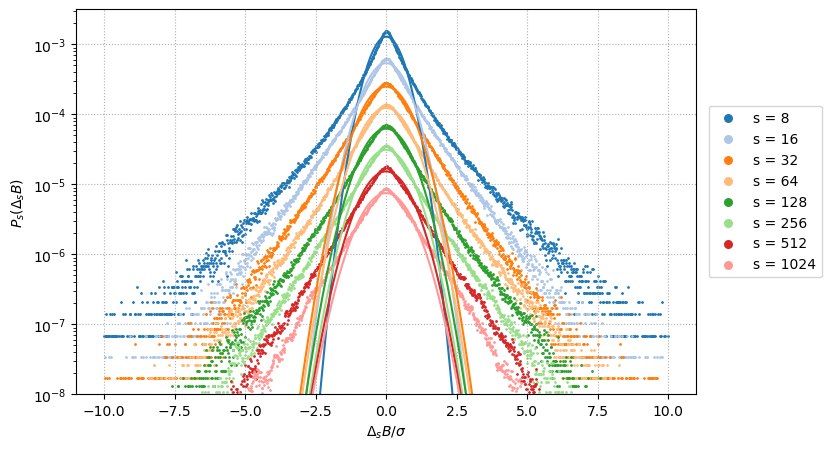

In [81]:

fig=plt.figure(figsize=(8,5))
for i, DBs in enumerate(list_Delta_B):
    counts, edges=np.histogram(DBs, bins=int(np.sqrt(DBs.size)), range=(-10, 10))
    bin_cen=(edges[1:]+edges[:-1])/2
        
    popt, pcov = curve_fit(gaus , bin_cen, counts/(S[i]*len(DBs)), p0=[1,1,1])
    
    x = np.linspace(-5, 5, 100)
    plt.plot(x, gaus(x, *popt), color=colors[i])
    
    plt.scatter(bin_cen, counts/(S[i]*len(DBs)), s=1, color=colors[i], label=f's = {S[i]}')


plt.yscale('log')
plt.ylim(1e-8, 10**(-2.5))
plt.ylabel(r'$P_s(\Delta_s B)$')
plt.xlabel(r'$\Delta_s B/\sigma$')
plt.legend(bbox_to_anchor=(1.02, 0.75), loc='upper left', borderaxespad=0)
lgnd=plt.legend(bbox_to_anchor=(1.02, 0.75), loc='upper left', borderaxespad=0)

#change the marker size manually for both lines
for legendHandles in lgnd.legendHandles:
    legendHandles._sizes = [30]

plt.grid(linestyle='dotted')
plt.savefig('Gaussian_fit_MIT.png', bbox_inches='tight')
plt.show()

## Plotting the fitted data using the Castaing equation


8 (lamda, sigma0) 0.7517940329364471 0.6371820186230686
16 (lamda, sigma0) 0.6414795016776743 0.7369942944085679
32 (lamda, sigma0) 0.5585129418139171 0.783025319597779
64 (lamda, sigma0) 0.5319986167979209 0.7830526789846286
128 (lamda, sigma0) 0.5331633411810061 0.7775848624092255
256 (lamda, sigma0) 0.5742881969145104 0.7836192180535295
512 (lamda, sigma0) 0.5807985770787161 0.7990768467881574
1024 (lamda, sigma0) 0.5568080948500573 0.8169981278545331


/tmp/ipykernel_998/1328272027.py:19: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(1e-7, 0)


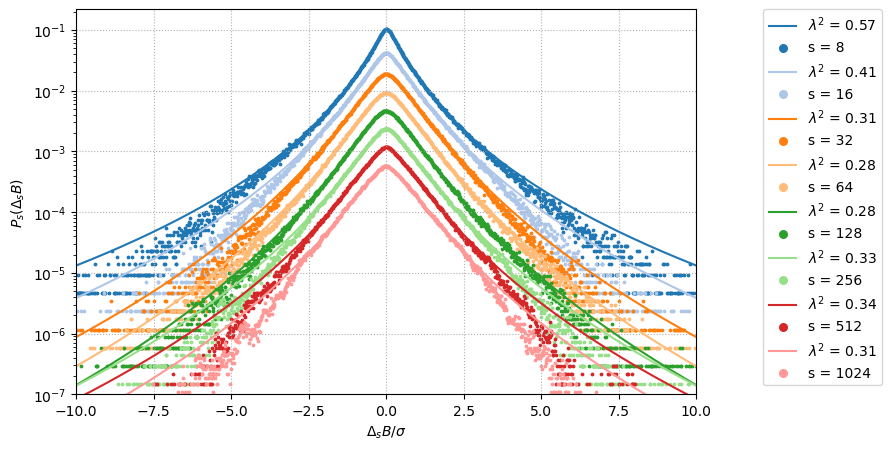

In [84]:
fig=plt.figure(figsize=(8,5))
for i,DBs in enumerate(list_Delta_B):
    
    counts, edges=np.histogram(DBs, bins=int(np.sqrt(DBs.size)), range=(-10, 10))
    bin_cen=(edges[1:]+edges[:-1])/2
    counts=counts/np.trapz(counts, bin_cen)
    
    popt, pcov = curve_fit(Castaing_integral, bin_cen, counts, p0=[np.sqrt(0.16), 1])
    
    x=np.linspace(-10, 10, 200)
    plt.plot(x, Castaing_integral(x, *popt)/S[i],  color=colors[i], label=r'$\lambda^2$ = {:.2f}'.format(*popt**2))
    print(S[i],'(lamda, sigma0)', *popt)

    plt.scatter(bin_cen, counts/S[i], s=3, label=f's = {S[i]}', color=colors[i])


plt.yscale('log')
plt.xlim(-10,10)
plt.ylim(1e-7, 0)
plt.xlabel(r'$\Delta_s B/\sigma$')
plt.ylabel(r'$P_s(\Delta_s B)$')
lgnd = plt.legend(bbox_to_anchor=(1.3, 1), borderaxespad=0)
for legendHandles in lgnd.legendHandles:
    legendHandles._sizes = [30]
plt.grid(linestyle='dotted')
plt.savefig('Castaing_fit_MIT.png', bbox_inches='tight')
plt.show()

## Generating the collapse plot from all data 

In [49]:
complete_dataset=np.concatenate(list_Delta_B)

(1459,) (1459,)
Chi squared 0.00029945451627523794
Chi squared g 0.001883942704153239


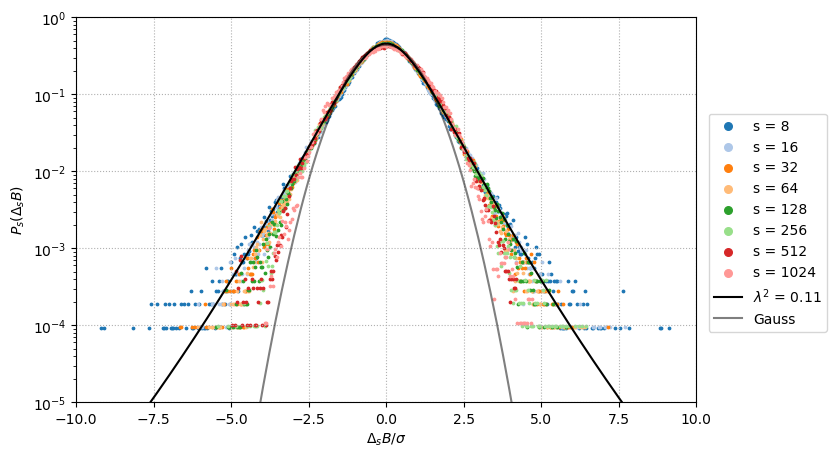

In [71]:
fig=plt.figure(figsize=(8,5))

for i,DBs in enumerate(list_Delta_B):
    counts, edges=np.histogram(DBs, bins=int(np.sqrt(DBs.size)), range=(-10, 10))
    bin_cen=(edges[1:]+edges[:-1])/2


    #print('SONO UGUALI?',len(d), np.sum(counts))
    counts=counts/np.trapz(counts, bin_cen)

    #print('Area after norm',np.trapz(counts, bin_cen))
    plt.scatter(bin_cen, counts, s=3, label=f's = {S[i]}' , color=colors[i])

    mu, std=norm.fit(counts, fscale=1) # to imporove to properly fit data


x=np.linspace(-10, 10, 200)
counts_all, edges_all=np.histogram(complete_dataset, bins=int(np.sqrt(complete_dataset.size)), range=(-10, 10))

bin_cen_all=(edges_all[1:]+edges_all[:-1])/2
counts_all=counts_all/np.trapz(counts_all, bin_cen_all)

popt, pcov = curve_fit(Castaing_integral, bin_cen_all, counts_all, p0=[np.sqrt(0.16), 1])
plt.plot(x, Castaing_integral(x, *popt), label=r'$\lambda^2$ = {:.2f}'.format(*popt**2), color='black')

popt_g, pcov_g = curve_fit(gaus, bin_cen_all, counts_all, p0=[np.sqrt(0.16), 1, 1])
plt.plot(x, gaus(x, *popt_g), label='Gauss', color='black', alpha=0.5)

print(counts_all.shape, Castaing_integral(bin_cen_all, *popt).shape)
#print('Chi all',chisquare(f_obs=counts_all, f_exp=Castaing_integral(bin_cen_all, *popt), ddof=2))
chi_2=np.sum((counts_all[counts_all!=0]-Castaing_integral(bin_cen_all[counts_all!=0], *popt))**2/(counts_all[counts_all!=0]))/(counts_all[counts_all!=0].shape[0]-2)
print('Chi squared', chi_2)

chi_2_g=np.sum((counts_all[counts_all!=0]-gaus(bin_cen_all[counts_all!=0], *popt_g))**2/(counts_all[counts_all!=0]))/(counts_all[counts_all!=0].shape[0]-2)
print('Chi squared g', chi_2_g)


plt.yscale('log')
plt.xlim(-10,10)
plt.ylim(1e-5, 1e0)
plt.xlabel(r'$\Delta_s B/\sigma$')
plt.ylabel(r'$P_s(\Delta_s B)$')
lgnd = plt.legend(bbox_to_anchor=(1.02, 0.75), loc='upper left', borderaxespad=0)
for legendHandles in lgnd.legendHandles:
    legendHandles._sizes = [30]
plt.grid(linestyle='dotted')
plt.savefig('Collapse_plot_Fantasia.png', bbox_inches='tight')
plt.show()



## Calculation and Plot of the fitting parameter $\lambda^2$ as function of s for different polynomial degree used in the detrending procedure

In [51]:
#Parameters 
S_dens=[int(1.5**i) for i in range(4, 17)] #value of the scale parameter s considered
poly_degrees=[i for i in range(2, 6)] #value of the poly degree considered for detrending

In [52]:
#Run only one time and the load the data in the next cell (long time off computation)

'''
#Calculation of the fitting parameter Lambda for differnt scale s and polynomial degree of fitting

#lambda_per_degree=[] #fit results for a given polynomial degree
lambda_list=[] #list of lists containing all the data for the final plot

#err_lambda_per_degree=[] #errors on fit results for a given polynomial degree
err_lambda_list=[] #list of lists containing all the errors on the fit parameters


#loop on different scale and polynomial degree and calculation
for degree in poly_degrees:
    print('Degree:', degree)
    
    lambda_per_degree=[] #fit results for a given polynomial degree
    err_lambda_per_degree=[] #errors on fit results for a given polynomial degree
         
    Delta_s_B_degree= increments(B, S_dens, polydegree=degree)
      
    for DBs in Delta_s_B_degree:
            
        counts, edges=np.histogram(DBs, bins=int(np.sqrt(DBs.size)), range=(-10, 10))
        bin_cen=(edges[1:]+edges[:-1])/2
        counts=counts/np.trapz(counts, bin_cen)   

        popt, pcov = curve_fit(Castaing_integral, bin_cen, counts, p0=[np.sqrt(0.16), 1])

        lambda_per_degree.append(popt[0])
        err_lambda_per_degree.append(np.sqrt(pcov[0,0]))

       
        
    lambda_list.append(lambda_per_degree)
    err_lambda_list.append(err_lambda_per_degree)
    

lambda_list=np.array(lambda_list)
err_lambda_list=np.array(err_lambda_list)

#print of the results in the files
filename1='lambda_fit.txt'
filename2='lambda_fit_error.txt'

np.savetxt(filename1, lambda_list)
np.savetxt(filename2, err_lambda_list)
'''

"\n#Calculation of the fitting parameter Lambda for differnt scale s and polynomial degree of fitting\n\n#lambda_per_degree=[] #fit results for a given polynomial degree\nlambda_list=[] #list of lists containing all the data for the final plot\n\n#err_lambda_per_degree=[] #errors on fit results for a given polynomial degree\nerr_lambda_list=[] #list of lists containing all the errors on the fit parameters\n\n\n#loop on different scale and polynomial degree and calculation\nfor degree in poly_degrees:\n    print('Degree:', degree)\n    \n    lambda_per_degree=[] #fit results for a given polynomial degree\n    err_lambda_per_degree=[] #errors on fit results for a given polynomial degree\n         \n    Delta_s_B_degree= increments(B, S_dens, polydegree=degree)\n      \n    for DBs in Delta_s_B_degree:\n            \n        counts, edges=np.histogram(DBs, bins=int(np.sqrt(DBs.size)), range=(-10, 10))\n        bin_cen=(edges[1:]+edges[:-1])/2\n        counts=counts/np.trapz(counts, bin_ce

In [53]:
#read data from the files
filename1='lambda_fit.txt'
filename2='lambda_fit_error.txt'

lambda_list=np.loadtxt(filename1)
err_lambda_list=np.loadtxt(filename2)



## Plot of $\lambda^2$ as function of s for different polynomial degrees

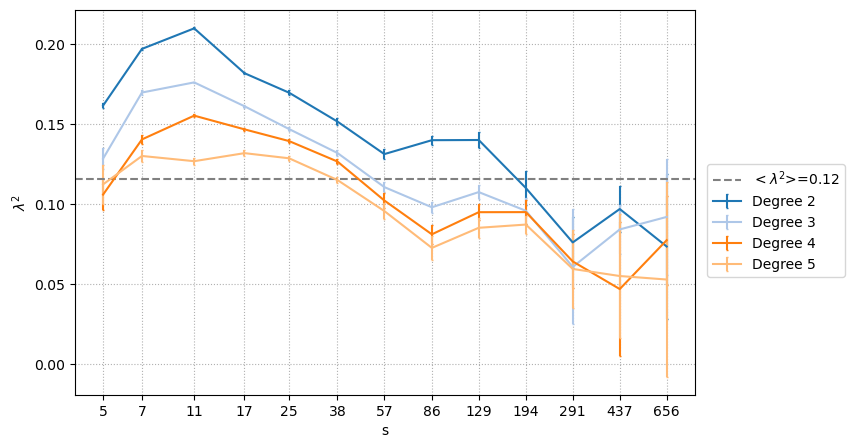

In [78]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
lambda_square=lambda_list**2 #calculation of lambda^2
err_lambda_square=(2*err_lambda_list/lambda_square)**2 #propagation of the error on lambda^2
mean_lambda_squared =np.mean(lambda_square)

for i in range(0,len(poly_degrees)):
    #print(S)
    #print(lambda_square[i,:])
    ax.errorbar(S_dens, lambda_square[i,:], err_lambda_square[i,:], label='Degree {}'.format(poly_degrees[i]), capsize=1, color=colors[i])

#Plot
""" fig, ax = plt.subplots(1,1)
ax.axhline(y=np.mean(lambda_square), linestyle='dashed', color='grey', label = r'$<\lambda^2$>' )
ax.legend(bbox_to_anchor=(1.02, 0.60), loc='upper left', borderaxespad=0)
ax.grid(linestyle='dotted')
ax.set_xscale('log', subs=[])
ax.set_xlabel('s')
ax.set_ylabel('$\lambda^2$') """

ax.axhline(y=mean_lambda_squared, linestyle='dashed', color='grey', label = fr'$<\lambda^2$>={mean_lambda_squared:.2f}' )
ax.legend(bbox_to_anchor=(1.02, 0.60), loc='upper left', borderaxespad=0)
ax.grid(linestyle='dotted')
ax.set_xscale('log', subs=[])
ax.set_xlabel('s')
ax.set_ylabel('$\lambda^2$')
ax.tick_params(axis='x', which='minor', bottom=False,top=False, labelbottom=False)
ax.xaxis.set_ticks(S_dens)
ax.set_xticklabels(labels=S_dens)
ax.set_xticks(S_dens)
plt.savefig('lambda_square.png', bbox_inches='tight')
plt.show()